In [1]:
import re
import unicodedata
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from env import user, password, host

def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'


url = get_db_url("spam_db")
sql = "SELECT * FROM spam"

from prepare import basic_clean, stem, lemmatize, remove_stopwords

[nltk_data] Downloading package stopwords to /Users/ken/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ken/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 1. Spam Data

- a. Load the spam data set.

In [2]:
df = pd.read_sql(sql, url, index_col="id")
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


- b. Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?

In [3]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']

def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [4]:
labels = pd.concat([df.label.value_counts(),
                    df.label.value_counts(normalize=True)], axis=1)
labels.columns = ['n', 'percent']
labels

,n,percent
ham,4825,0.865937
spam,747,0.134063


In [5]:
ham_words = clean(' '.join(df[df.label == 'ham'].text))
spam_words = clean(' '.join(df[df.label == 'spam'].text))
all_words = clean(' '.join(df.text))

In [6]:
ham_freq = pd.Series(ham_words).value_counts()
spam_freq = pd.Series(spam_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

spam_freq.head()

call    359
free    216
txt     150
ur      144
text    137
dtype: int64

In [7]:
word_counts = (pd.concat([all_freq, ham_freq, spam_freq], axis=1, sort=True)
                .set_axis(['all', 'ham', 'spam'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head()

,all,ham,spam
0,3,0,3
008704050406,2,0,2
0089my,1,0,1
0121,1,0,1
01223585236,1,0,1


In [8]:
word_counts.sort_values(by='all', ascending=False)

,all,ham,spam
call,600,241,359
im,462,449,13
get,397,314,83
ur,384,240,144
go,304,273,31
...,...,...,...
lunchtime,1,1,0
bailiff,1,0,1
lul,1,1,0
luks,1,1,0


In [9]:
top_20_ham_bigrams = (pd.Series(nltk.ngrams(ham_words, 2))
                      .value_counts()
                      .head(20))

top_20_ham_bigrams.head()

(call, later)    52
(ill, call)      48
(let, know)      42
(sorry, ill)     39
(dont, know)     32
dtype: int64

In [10]:
top_20_spam_bigrams = (pd.Series(nltk.ngrams(spam_words, 2))
                      .value_counts()
                      .head(20))

top_20_spam_bigrams.head()

(please, call)         44
(customer, service)    27
(po, box)              24
(guaranteed, call)     23
(a1000, cash)          23
dtype: int64

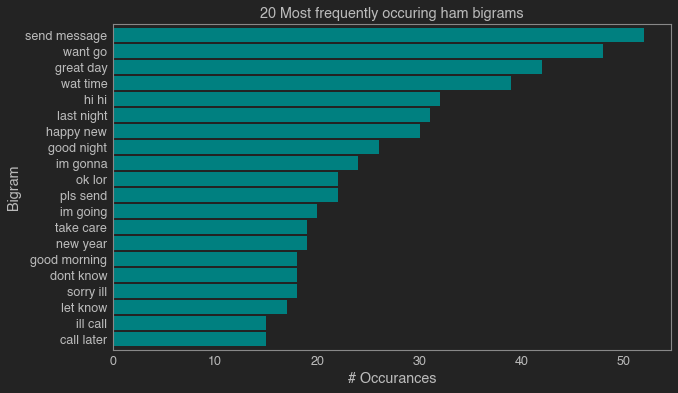

In [11]:
from jupyterthemes import jtplot
jtplot.style(grid=False)

top_20_ham_bigrams.sort_values().plot.barh(color='teal', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ham bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ham_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

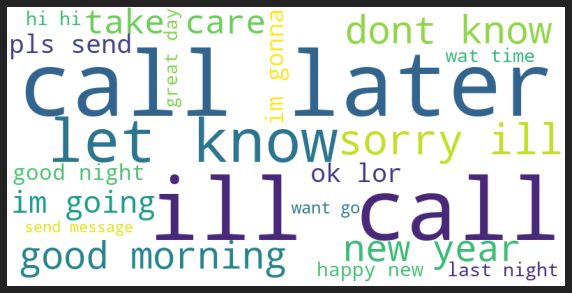

In [12]:
from wordcloud import WordCloud
data = {k[0] + ' ' + k[1]: v for k, v in top_20_ham_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

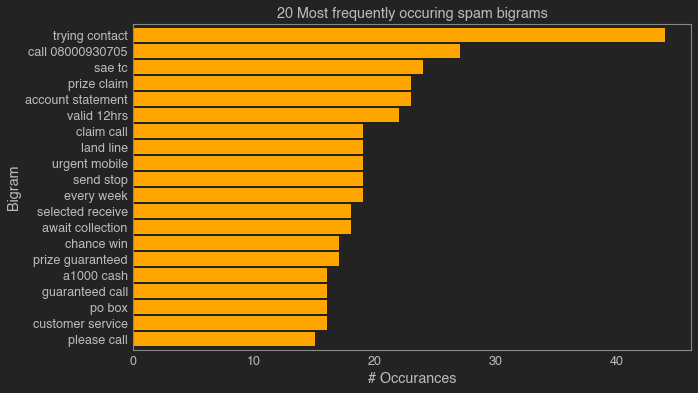

In [13]:
top_20_spam_bigrams.sort_values().plot.barh(color='orange', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring spam bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_spam_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

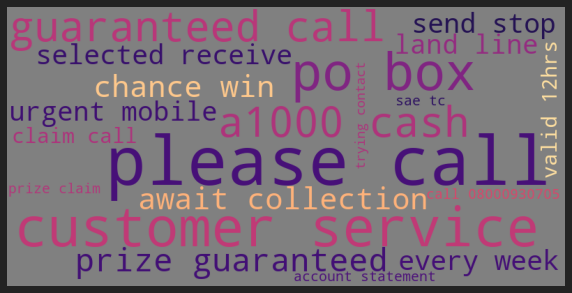

In [14]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_spam_bigrams.to_dict().items()}
img = WordCloud(background_color='gray',colormap='magma', width=800, height=400).generate_from_frequencies(data) 
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

- c. Is there any overlap in the bigrams for the spam data and the ham data?

In [15]:
top_20_ham_bigrams

(call, later)      52
(ill, call)        48
(let, know)        42
(sorry, ill)       39
(dont, know)       32
(good, morning)    31
(new, year)        30
(take, care)       26
(im, going)        24
(pls, send)        22
(ok, lor)          22
(im, gonna)        20
(good, night)      19
(happy, new)       19
(last, night)      18
(hi, hi)           18
(wat, time)        18
(great, day)       17
(want, go)         15
(send, message)    15
dtype: int64

In [16]:
top_20_spam_bigrams

(please, call)          44
(customer, service)     27
(po, box)               24
(guaranteed, call)      23
(a1000, cash)           23
(prize, guaranteed)     22
(chance, win)           19
(await, collection)     19
(selected, receive)     19
(every, week)           19
(send, stop)            19
(urgent, mobile)        18
(land, line)            18
(claim, call)           17
(valid, 12hrs)          17
(account, statement)    16
(prize, claim)          16
(sae, tc)               16
(call, 08000930705)     16
(trying, contact)       15
dtype: int64

- d. Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.

In [17]:
top_20_ham_trigrams = (pd.Series(nltk.ngrams(ham_words, 3))
                      .value_counts()
                      .head(20))

top_20_ham_trigrams.head()

(ill, call, later)      42
(sorry, ill, call)      38
(happy, new, year)      19
(pls, send, message)    13
(right, pls, send)      12
dtype: int64

In [18]:
top_20_spam_trigrams = (pd.Series(nltk.ngrams(spam_words, 3))
                      .value_counts()
                      .head(20))

top_20_spam_trigrams.head()

(prize, guaranteed, call)     21
(call, customer, service)     15
(land, line, claim)           14
(reply, call, 08000930705)    14
(private, 2003, account)      13
dtype: int64

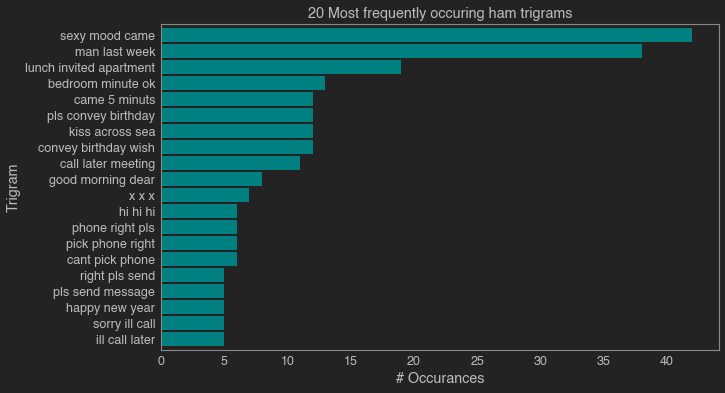

In [19]:
top_20_ham_trigrams.sort_values().plot.barh(color='teal', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ham trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ham_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

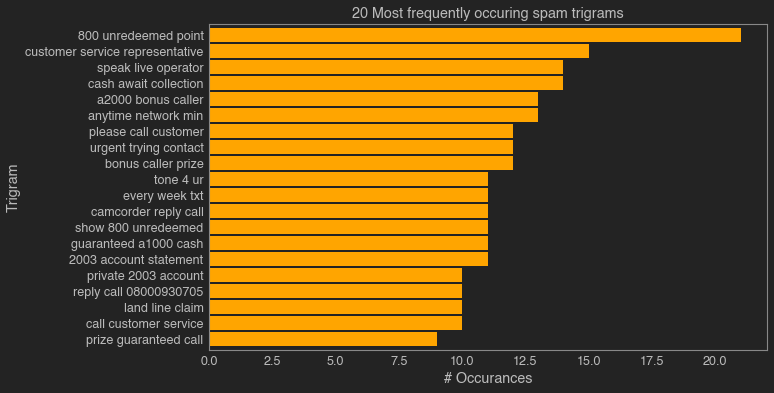

In [20]:
top_20_spam_trigrams.sort_values().plot.barh(color='orange', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring spam trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_spam_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

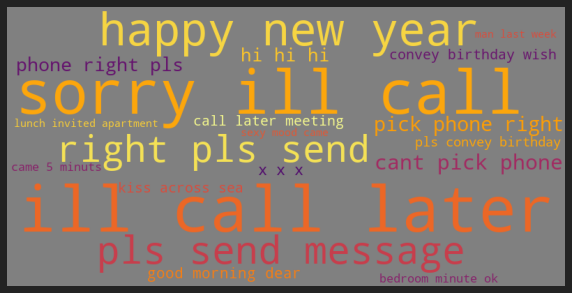

In [21]:
data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in top_20_ham_trigrams.to_dict().items()}
img = WordCloud(background_color='grey', colormap='inferno', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

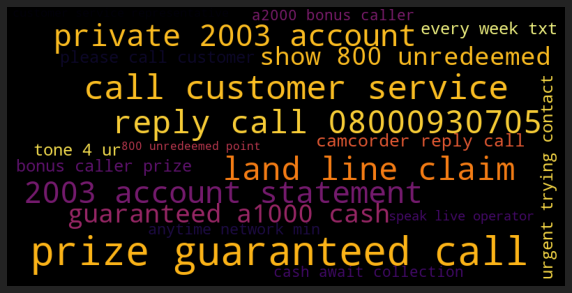

In [22]:
data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in top_20_spam_trigrams.to_dict().items()}
img = WordCloud(background_color='black', colormap='inferno', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

# 2. Explore the blog articles using the techniques discussed in the exploration lesson.

In [23]:
from ryan_acquire import acquire_news_articles, acquire_codeup_blog

In [24]:
codeup_df = acquire_codeup_blog()
codeup_df.head()

/Users/ken/codeup-data-science/natural-language-processing-exercises/ryan_acquire.py:16: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 16 of the file /Users/ken/codeup-data-science/natural-language-processing-exercises/ryan_acquire.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  soup = BeautifulSoup(response.text)


,title,published_date,blog_image,content
0,Codeup’s Data Science Career Accelerator is Here!,"September 30, 2018",https://codeup.com/wp-content/uploads/2018/10/...,The rumors are true! The time has arrived. Cod...
1,Data Science Myths,"October 31, 2018",https://codeup.com/wp-content/uploads/2018/10/...,By Dimitri Antoniou and Maggie Giust\nData Sci...
2,Data Science VS Data Analytics: What’s The Dif...,"October 17, 2018",https://codeup.com/wp-content/uploads/2018/10/...,"By Dimitri Antoniou\nA week ago, Codeup launch..."
3,10 Tips to Crush It at the SA Tech Job Fair,"August 14, 2018",None,SA Tech Job Fair\nThe third bi-annual San Anto...
4,Competitor Bootcamps Are Closing. Is the Model...,"August 14, 2018",None,Competitor Bootcamps Are Closing. Is the Model...


In [25]:
codeup_df = codeup_df.rename({'content':'original'},axis=1)
codeup_df['clean'] = codeup_df.original.apply(lambda x: basic_clean(x))
codeup_df['stemmed'] = codeup_df.clean.apply(lambda x: stem(x))
codeup_df['lemmatized'] = codeup_df.clean.apply(lambda x: lemmatize(x))
codeup_df['stopwords_removed'] = codeup_df.lemmatized.apply(lambda x: remove_stopwords(x))
codeup_df.head()

,title,published_date,blog_image,original,clean,stemmed,lemmatized,stopwords_removed
0,Codeup’s Data Science Career Accelerator is Here!,"September 30, 2018",https://codeup.com/wp-content/uploads/2018/10/...,The rumors are true! The time has arrived. Cod...,the rumors are true the time has arrived codeu...,the rumor are true the time ha arriv codeup ha...,the rumor are true the time ha arrived codeup ...,rumor true time ha arrived codeup ha officiall...
1,Data Science Myths,"October 31, 2018",https://codeup.com/wp-content/uploads/2018/10/...,By Dimitri Antoniou and Maggie Giust\nData Sci...,by dimitri antoniou and maggie giust\ndata sci...,by dimitri antoni and maggi giust data scienc ...,by dimitri antoniou and maggie giust data scie...,dimitri antoniou maggie giust data science big...
2,Data Science VS Data Analytics: What’s The Dif...,"October 17, 2018",https://codeup.com/wp-content/uploads/2018/10/...,"By Dimitri Antoniou\nA week ago, Codeup launch...",by dimitri antoniou\na week ago codeup launche...,by dimitri antoni a week ago codeup launch our...,by dimitri antoniou a week ago codeup launched...,dimitri antoniou week ago codeup launched imme...
3,10 Tips to Crush It at the SA Tech Job Fair,"August 14, 2018",None,SA Tech Job Fair\nThe third bi-annual San Anto...,sa tech job fair\nthe third biannual san anton...,sa tech job fair the third biannual san antoni...,sa tech job fair the third biannual san antoni...,sa tech job fair third biannual san antonio te...
4,Competitor Bootcamps Are Closing. Is the Model...,"August 14, 2018",None,Competitor Bootcamps Are Closing. Is the Model...,competitor bootcamps are closing is the model ...,competitor bootcamp are close is the model in ...,competitor bootcamps are closing is the model ...,competitor bootcamps closing model danger prog...


In [26]:
all_blog_words = ' '.join(codeup_df.stopwords_removed)
all_blog_words

'rumor true time ha arrived codeup ha officially opened application new data science career accelerator 25 seat available immersive program one kind san antonio help land job glassdoors 1 best job america data science method providing actionable intelligence data data revolution ha hit san antonio resulting explosion data scientist position across company like usaa accenture booz allen hamilton heb weve even seen utsa invest 70 cybersecurity center school data science built program specifically meet growing demand industry program 18 week long fulltime handson projectbased curriculum development instruction led senior data scientist maggie giust ha worked heb capital group rackspace along input dozen practitioner hiring partner student work real data set realistic problem entire data science pipeline collection deployment receive professional development training resume writing interviewing continuing education prepare smooth transition workforce focus applied data science immediate im

In [27]:
all_blog_words = pd.Series(all_blog_words.split())

In [28]:
all_blog_words.value_counts().head(20)

data         75
science      26
company      20
learning     20
job          14
machine      14
scientist    13
model        12
like         12
education    10
one          10
fair          9
work          9
new           9
time          8
statistic     8
make          8
business      8
student       7
look          7
dtype: int64

In [29]:
all_cloud = WordCloud(background_color='grey', colormap='Greens_r', height=600, width=1000).generate(' '.join(all_blog_words))

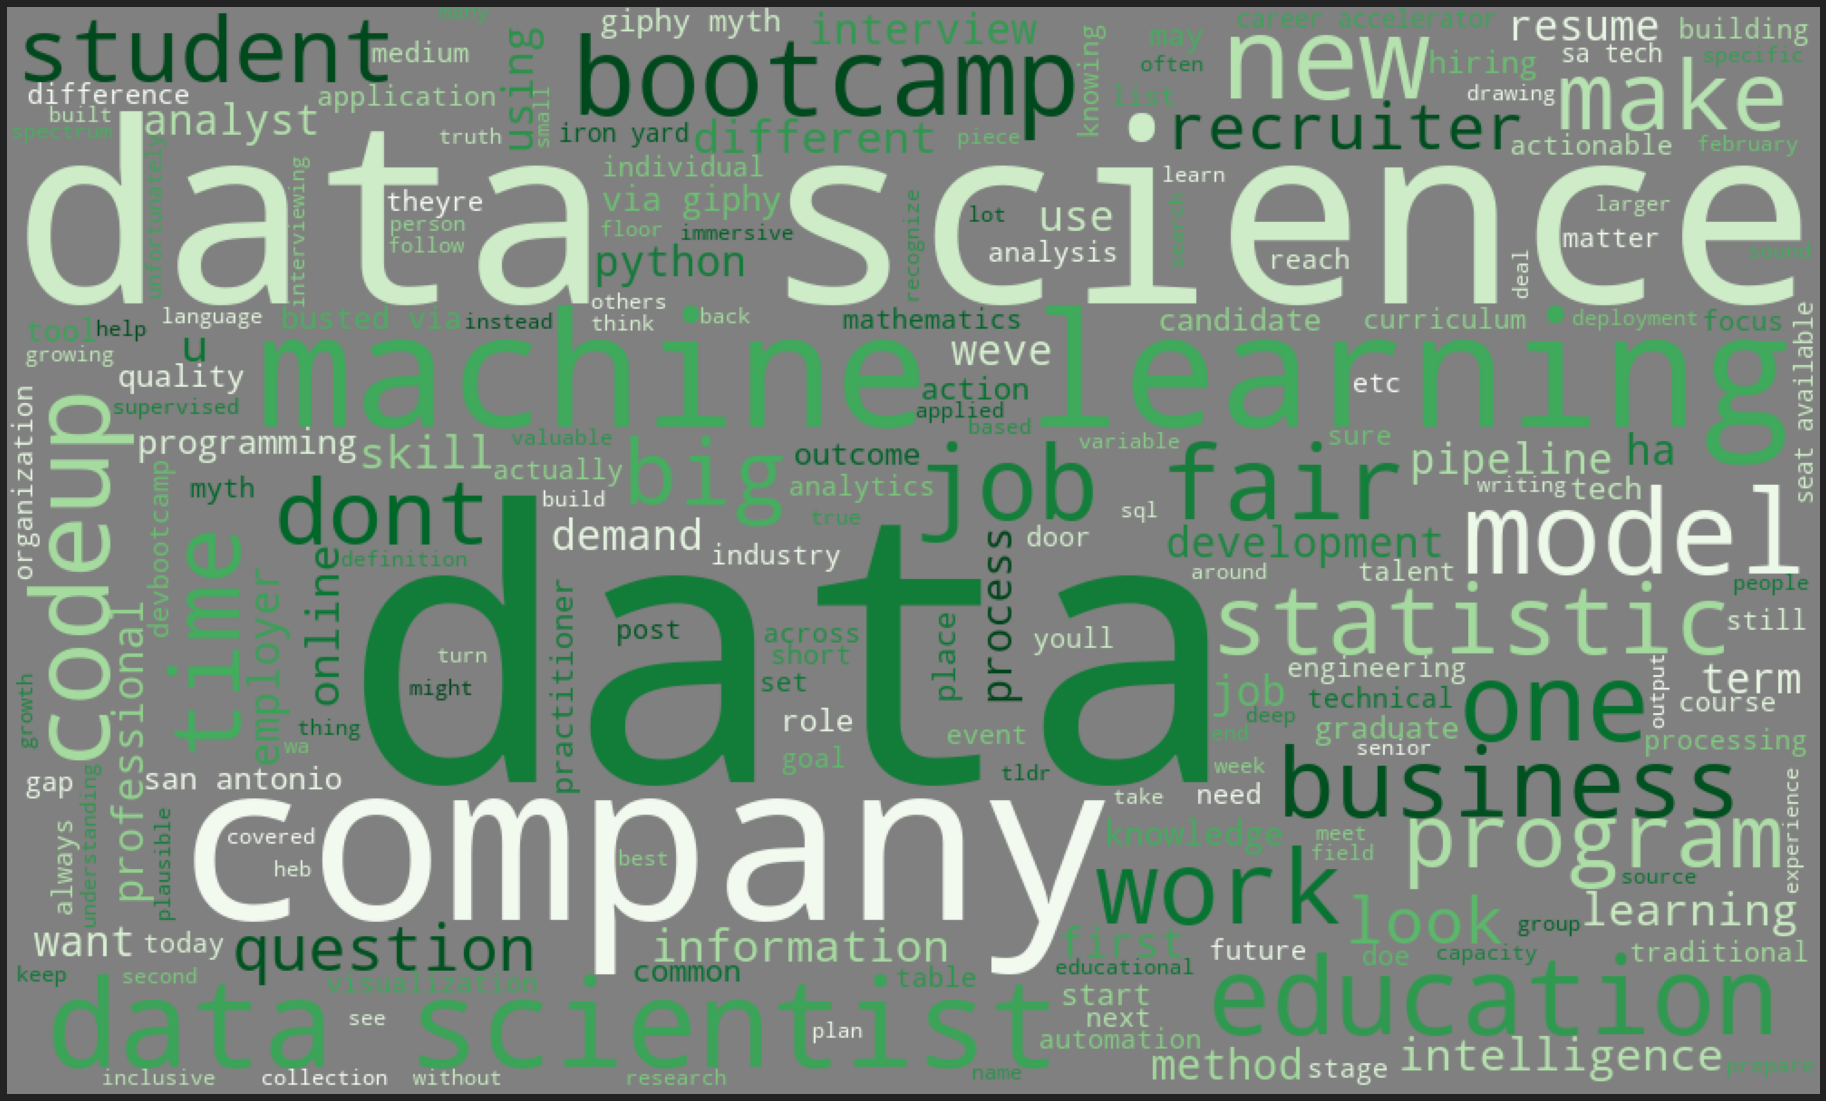

In [30]:
plt.figure(figsize=(100,20))
plt.axis('off')
plt.imshow(all_cloud)

In [31]:
top_20_codeup_bigrams = (pd.Series(nltk.ngrams(all_blog_words, 2))
                      .value_counts()
                      .head(20))

top_20_codeup_bigrams.head()

(data, science)        26
(machine, learning)    14
(data, scientist)      13
(job, fair)             9
(via, giphy)            5
dtype: int64

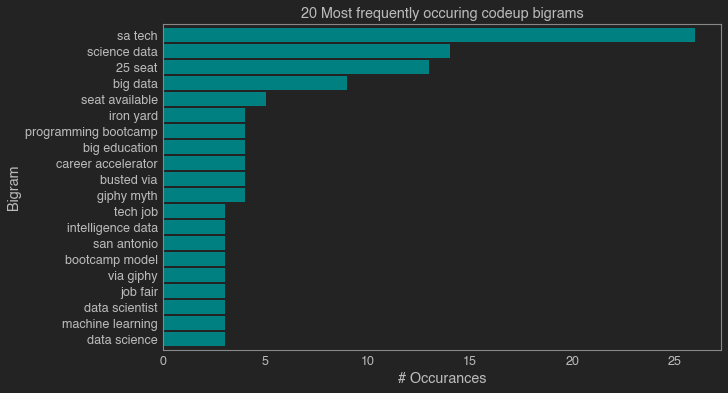

In [32]:
top_20_codeup_bigrams.sort_values().plot.barh(color='teal', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring codeup bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_codeup_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

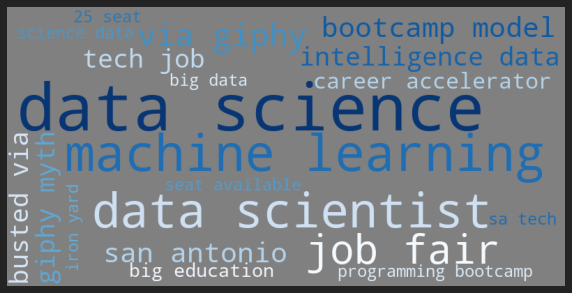

In [33]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_codeup_bigrams.to_dict().items()}
img = WordCloud(background_color='grey',colormap='Blues_r', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

In [34]:
top_20_codeup_trigrams = (pd.Series(nltk.ngrams(all_blog_words, 3))
                      .value_counts()
                      .head(20))

top_20_codeup_trigrams.head()

(tech, job, fair)        4
(via, giphy, myth)       4
(busted, via, giphy)     4
(sa, tech, job)          3
(25, seat, available)    3
dtype: int64

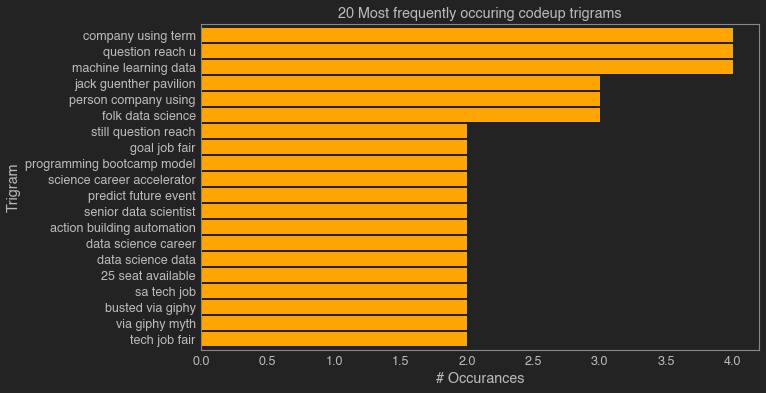

In [35]:
top_20_codeup_trigrams.sort_values().plot.barh(color='orange', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring codeup trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_codeup_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

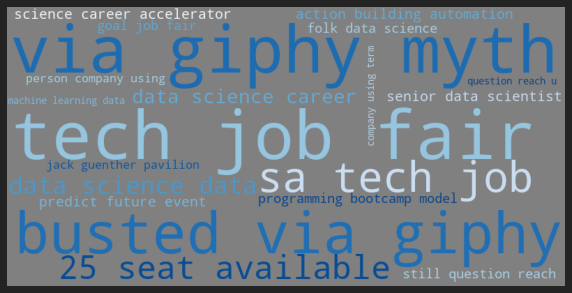

In [36]:
data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in top_20_codeup_trigrams.to_dict().items()}
img = WordCloud(background_color='grey', colormap='Blues', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

# 3. Explore the news articles using the techniques discussed in the exploration lesson. Use the category variable when exploring.

In [37]:

from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
def tokenize(string):
    '''
    This function takes in a string and
    returns a tokenized string.
    '''
    # Create tokenizer.
    tokenizer = nltk.tokenize.ToktokTokenizer()
    
    # Use tokenizer
    string = tokenizer.tokenize(string, return_str=True)
    
    return string

def prep_article_data(df, column, extra_words=[], exclude_words=[]):
    '''
    This function take in a df and the string name for a text column with 
    option to pass lists for extra_words and exclude_words and
    returns a df with the text article title, original text, stemmed text,
    lemmatized text, cleaned, tokenized, & lemmatized text with stopwords removed.
    '''
    df['clean'] = df[column].apply(basic_clean)\
                            .apply(tokenize)\
                            .apply(remove_stopwords, 
                                   extra_words=extra_words, 
                                   exclude_words=exclude_words)
    
    df['stemmed'] = df[column].apply(basic_clean)\
                            .apply(tokenize)\
                            .apply(stem)\
                            .apply(remove_stopwords, 
                                   extra_words=extra_words, 
                                   exclude_words=exclude_words)
    
    df['lemmatized'] = df[column].apply(basic_clean)\
                            .apply(tokenize)\
                            .apply(lemmatize)\
                            .apply(remove_stopwords, 
                                   extra_words=extra_words, 
                                   exclude_words=exclude_words)
    
    return df[['title', column,'clean', 'stemmed', 'lemmatized','category']]


In [38]:
news_df = acquire_news_articles()
news_df.head()

/Users/ken/codeup-data-science/natural-language-processing-exercises/ryan_acquire.py:92: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 92 of the file /Users/ken/codeup-data-science/natural-language-processing-exercises/ryan_acquire.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  soup = BeautifulSoup(response.text)


,title,content,category
0,UBS Group donates ₹11 crore for COVID-19 relie...,Swiss investment bank UBS Group AG on Wednesda...,business
1,Have faith in India's ability to come out of C...,RBI Governor Shaktikanta Das said that he has ...,business
2,"RBI's ₹50,000 cr liquidity support a welcome m...",Apollo Hospitals Group Joint MD Dr Sangita Red...,business
3,2nd COVID-19 wave has impacted India's nascent...,Finance Minister Nirmala Sitharaman said that ...,business
4,Global task force of 40 US firms' CEOs launch ...,A global task force of CEOs of top 40 American...,business


In [39]:
news_df = prep_article_data(news_df,'content')
news_df.head()

,title,content,clean,stemmed,lemmatized,category
0,UBS Group donates ₹11 crore for COVID-19 relie...,Swiss investment bank UBS Group AG on Wednesda...,swiss investment bank ubs group ag wednesday a...,swiss invest bank ub group ag wednesday announ...,swiss investment bank ubs group ag wednesday a...,business
1,Have faith in India's ability to come out of C...,RBI Governor Shaktikanta Das said that he has ...,rbi governor shaktikanta das said faith india ...,rbi governor shaktikanta da said ha faith indi...,rbi governor shaktikanta da said ha faith indi...,business
2,"RBI's ₹50,000 cr liquidity support a welcome m...",Apollo Hospitals Group Joint MD Dr Sangita Red...,apollo hospitals group joint md dr sangita red...,apollo hospit group joint md dr sangita reddi ...,apollo hospital group joint md dr sangita redd...,business
3,2nd COVID-19 wave has impacted India's nascent...,Finance Minister Nirmala Sitharaman said that ...,finance minister nirmala sitharaman said resur...,financ minist nirmala sitharaman said resurg c...,finance minister nirmala sitharaman said resur...,business
4,Global task force of 40 US firms' CEOs launch ...,A global task force of CEOs of top 40 American...,global task force ceos top 40 american compani...,global task forc ceo top 40 american compani p...,global task force ceo top 40 american company ...,business


In [40]:
news_df.category.value_counts()

sports           25
technology       25
world            25
business         25
entertainment    25
science          24
Name: category, dtype: int64

In [41]:
sports_words = ' '.join(news_df[news_df.category == 'sports'].lemmatized).replace("'",'')
technology_words = ' '.join(news_df[news_df.category == 'technology'].lemmatized).replace("'",'')
entertainment_words = ' '.join(news_df[news_df.category == 'entertainment'].lemmatized).replace("'",'')
world_words = ' '.join(news_df[news_df.category == 'world'].lemmatized).replace("'",'')
business_words = ' '.join(news_df[news_df.category == 'business'].lemmatized).replace("'",'')
science_words = ' '.join(news_df[news_df.category == 'science'].lemmatized).replace("'",'')

In [42]:
science_words_count = pd.Series(science_words.split())
science_words_count.value_counts()

space       22
ha          16
spacex      15
station     11
said        11
            ..
ceremony     1
japanese     1
include      1
bill         1
stich        1
Length: 548, dtype: int64

In [50]:
science_words = science_words.replace('u','').replace('ha','')

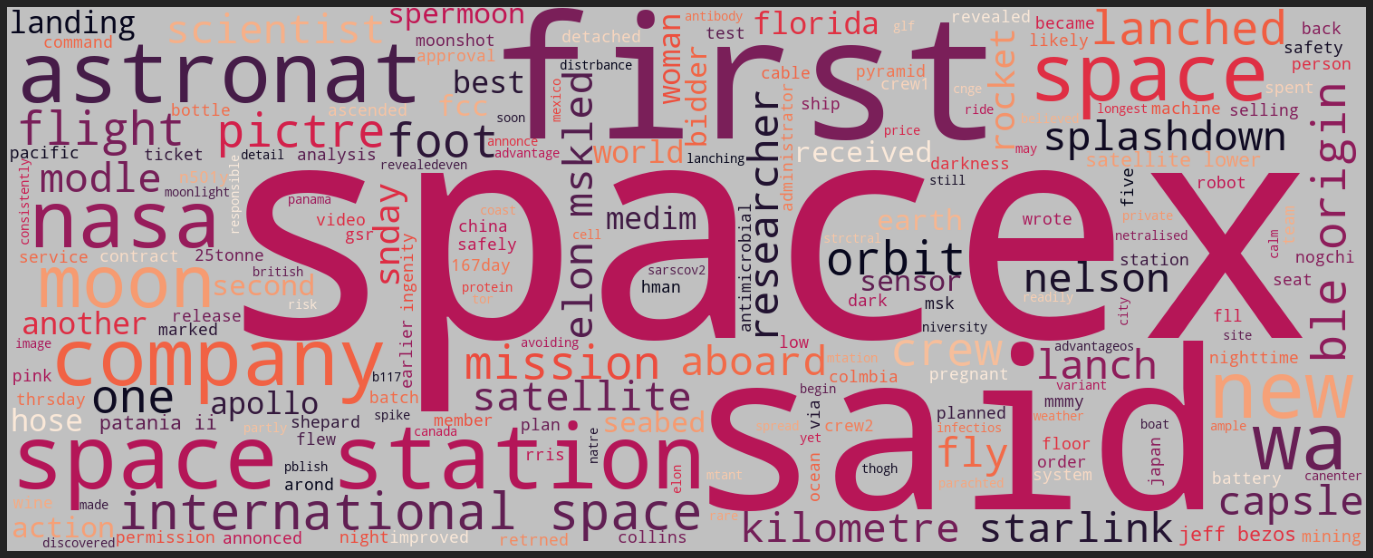

In [53]:
science_cloud = WordCloud(background_color='silver', colormap='rocket', height=600, width=1500).generate(science_words)
plt.figure(figsize=(200,10))
plt.axis('off')
plt.imshow(science_cloud)


In [44]:
top_20_science_bigrams = (pd.Series(nltk.ngrams(science_words.split(), 2))
                      .value_counts()
                      .head(20))

top_20_science_bigrams.head()

(space, station)          9
(international, space)    6
(blue, origin)            5
(elon, muskled)           4
(spacex, ha)              4
dtype: int64

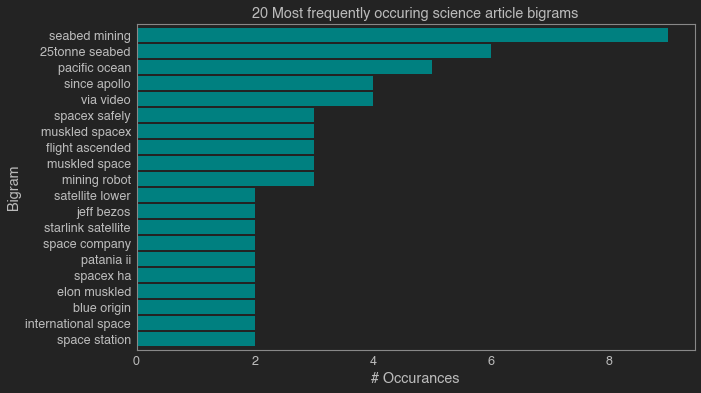

In [45]:
top_20_science_bigrams.sort_values().plot.barh(color='teal', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring science article bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_science_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

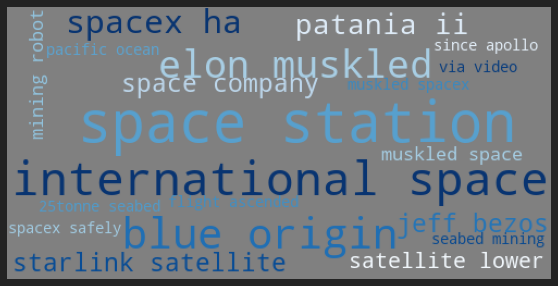

In [46]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_science_bigrams.to_dict().items()}
img = WordCloud(background_color='grey',colormap='Blues_r', width=500, height=250).generate_from_frequencies(data)
plt.figure(figsize=(50, 5))
plt.imshow(img)
plt.axis('off')
plt.show()